In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim as gs

from kl_tools.galaxy_fitter import estimate_gal_properties
from kl_tools.parameters import ImagePars
from kl_tools.plotting import plot
from kl_tools.utils import get_base_dir, MidpointNormalize, build_map_grid

In [2]:
show = True
use_psf = True
use_galsim = True
basis_plane = 'disk'

if use_psf is False:
    draw_method = 'real_space'
else:
    draw_method = 'auto'

Nrow = 30
Ncol = 50
pixel_scale = 0.5 # arcsec
image_pars = ImagePars(
    shape=(Nrow, Ncol),
    indexing='ij',
    pixel_scale=pixel_scale
)

Nx = image_pars.Nx
Ny = image_pars.Ny

if use_psf:
    psf_sigma = 2.25*pixel_scale # arcsec
    # psf_sigma = 0.01 # arcsec
    psf = gs.Gaussian(
        sigma=psf_sigma,
        flux=1.0,
    )
else:
    psf = None

Using GalSim to generate image


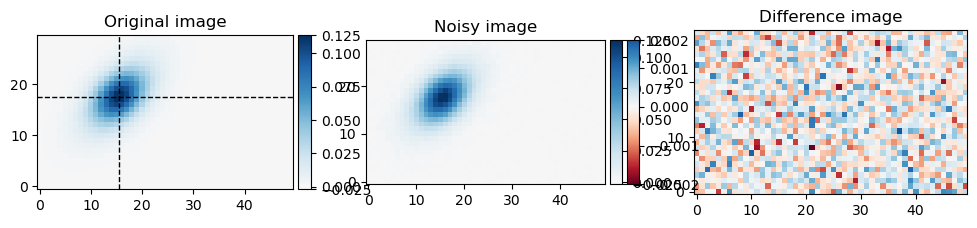

In [3]:
flux = 10.0
scale_radius = 1.5 # arcsec
# scale_radius = 3.0 # arcsec
# scale_radius = 6.0 # arcsec
offset_pixels = np.array([-9., 3.]) # pixels
# offset_pixels = np.array([-20, 15]) # pixels
offset = pixel_scale * offset_pixels # arcsec
sini = 0.9
theta_int = np.pi / 4. * gs.radians
inclination = np.arcsin(sini) * gs.radians

if use_galsim is True:
    print('Using GalSim to generate image')
    obj = gs.InclinedExponential(
        inclination,
        flux=flux,
        scale_radius=scale_radius
    )

    obj = obj.rotate(theta_int)

    if use_psf is True:
        obj = gs.Convolution(obj, psf)
    else:
        psf = None

    image = obj.drawImage(
        scale=image_pars.pixel_scale,
        offset=gs.PositionD(offset_pixels[0], offset_pixels[1]),
        nx=Nx,
        ny=Ny,
        method='no_pixel'
    ).array

else:
    print('Using numpy to generate image')
    # centered at (0, 0) in pixel coordinates
    X, Y = build_map_grid(Nx, Ny, indexing='xy')
    R = np.sqrt((X-offset[0])**2 + (Y-offset[1])**2)

    # parameters for synthetic exponential profile
    I0 = 1.23
    r_s = scale_radius / pixel_scale

    image = I0 * np.exp(-R / r_s)

# add noise
im_peak = image.flatten().max()

noise_std = 0.005 * im_peak
noise = np.random.normal(
    loc=0.0,
    scale=noise_std,
    size=image.shape
)
image_noisy = image + noise

vmin = min(image.flatten().min(), image_noisy.flatten().min())
vmax = max(image.flatten().max(), image_noisy.flatten().max())
norm = MidpointNormalize(vmin=vmin, vmax=vmax)
cmap = 'RdBu'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

im1 = ax1.imshow(image, origin='lower', cmap=cmap, norm=norm)
ax1.set_title('Original image')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax1.axhline(offset_pixels[1]+Ny/2.-0.5, color='k', linestyle='--', lw=1)
ax1.axvline(offset_pixels[0]+Nx/2.-0.5, color='k', linestyle='--', lw=1)
plt.colorbar(im1, cax=cax)

im2 = ax2.imshow(image_noisy, origin='lower', cmap=cmap, norm=norm)
ax2.set_title('Noisy image')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

diff = image_noisy - image
norm = MidpointNormalize(vmin=np.min(diff), vmax=np.max(diff))
im3 = ax3.imshow(image_noisy-image, origin='lower', cmap=cmap, norm=norm)
ax3.set_title('Difference image')
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax)

if show:
    plt.show()
else:
    plt.close()

In [4]:
guess = {
    'flux': 10, # add some error
    'scale_radius': 2 * scale_radius, # add some error
    'sini': 0.5,  # no inclination
    'theta_int': np.pi/6,  # no rotation
    'x0': 0.5*offset[0],  # x offset in pixels
    'y0': 0.5*offset[1],  # y offset in pixels
}
bounds = {
    'flux': (1e-4, 1e4),  # flux must be positive
    'scale_radius': (0.01, 10),  # scale radius must be positive
    # 'x0': (-Nx/2, Nx/2),  # x offset in pixels
    # 'y0': (-Ny/2, Ny/2),  # y offset in pixels
}

gsparams = gs.GSParams(
    maximum_fft_size=2**16
)

result = estimate_gal_properties(
    image_noisy,
    image_pars,
    guess,
    bounds,
    sersic_n=1.0,
    psf=psf,
    draw_image_kwargs={'method': draw_method},
    gsparams=gsparams,
    optimizer='differential_evolution',
    optimize_kwargs={'tol': 1e-6},
)

dict_keys(['params', 'model_image', 'success', 'message', 'fun'])
fit_pars: {'flux': 10.004771344693836, 'scale_radius': 1.4938602676300556, 'sini': 0.9012736566551207, 'theta_int': 0.7842593104216236, 'x0': -4.498203929039322, 'y0': 1.502224634921312}
Estimated flux: 10.005 (true: 10.0)
Estimated scale radius: 1.494 (true: 1.5
Estimated x offset: -4.498 (true: -4.5)
Estimated y offset: 1.502 (true: 1.5)


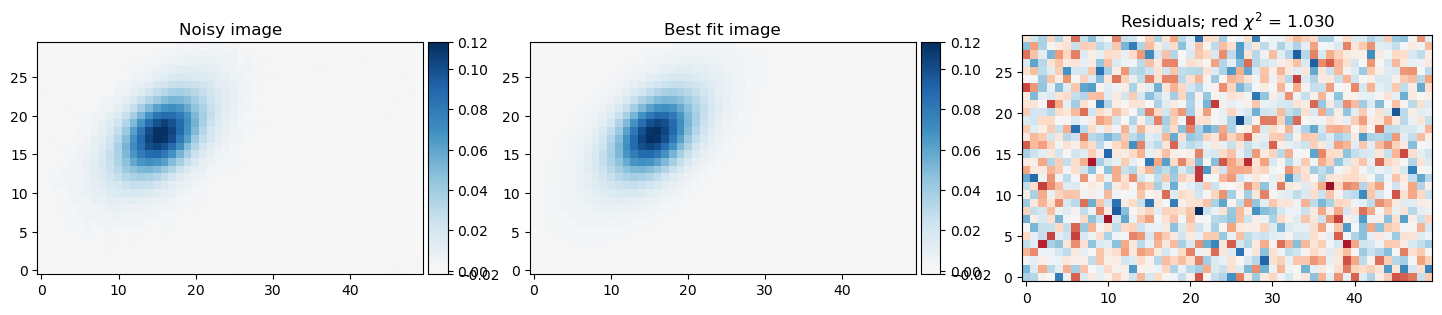

In [5]:
print(result.keys())
fit_pars = result['params']
print('fit_pars:', fit_pars)
model_image = result['model_image']

print(f"Estimated flux: {fit_pars['flux']:.3f} (true: {flux})")
print(f"Estimated scale radius: {fit_pars['scale_radius']:.3f} (true: {scale_radius}")
print(f"Estimated x offset: {fit_pars['x0']:.3f} (true: {offset[0]})")
print(f"Estimated y offset: {fit_pars['y0']:.3f} (true: {offset[1]})")

vmin = min(model_image.flatten().min(), image_noisy.flatten().min())
vmax = max(model_image.flatten().max(), image_noisy.flatten().max())
norm = MidpointNormalize(vmin=vmin, vmax=vmax)
cmap = 'RdBu'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

im1 = ax1.imshow(image_noisy, origin='lower', cmap=cmap, norm=norm)
ax1.set_title('Noisy image')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)

im2 = ax2.imshow(model_image, origin='lower', cmap=cmap, norm=norm)
ax2.set_title('Best fit image')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

diff = model_image - image_noisy
red_chi2 = np.sum((diff/noise_std)**2) / (image_noisy.size - len(fit_pars))
norm = MidpointNormalize(vmin=np.min(diff), vmax=np.max(diff))
im3 = ax3.imshow(diff, origin='lower', cmap=cmap, norm=norm)
ax3.set_title(f'Residuals; red $\chi^2$ = {red_chi2:.3f}')
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im3, cax=cax)

plt.gcf().set_size_inches(18, 4)
if show:
    plt.show()
else:
    plt.close()

# Moving on to Intensity Maps
Now that we have a good starting point, let's use this info to build KL-tools imaps

In [6]:
from kl_tools.intensity import build_intensity_map

# sampled pars in the style of the rest of kl_tools
theta_pars = {
    'sini': fit_pars['sini'],
    'theta_int': fit_pars['theta_int'],
    'x0': fit_pars['x0'],
    'y0': fit_pars['y0'],
    'g1': 0.0,  # no shear
    'g2': 0.0,  # no shear
}

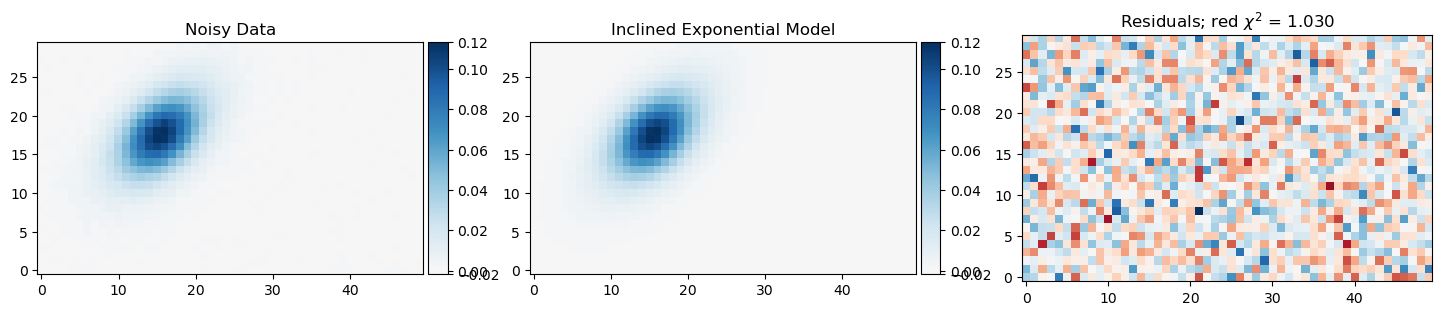

Red chi2 for imap model: 1.0305
Red chi2 for gal_fitter: 1.0305


In [7]:
inclined_exp_pars = {
    'flux': fit_pars['flux'],
    'scale_radius': fit_pars['scale_radius'],
}
inclined_exp_imap = build_intensity_map('inclined_exp', inclined_exp_pars)

inclined_exp_image = inclined_exp_imap.render(
    image_pars,
    theta_pars,
    pars={'psf': psf}
)

vmin = min(inclined_exp_image.flatten().min(), image_noisy.flatten().min())
vmax = max(inclined_exp_image.flatten().max(), image_noisy.flatten().max())
norm = MidpointNormalize(vmin=vmin, vmax=vmax)
cmap = 'RdBu'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

im = ax1.imshow(image_noisy, origin='lower', cmap=cmap, norm=norm)
ax1.set_title('Noisy Data')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)

im = ax2.imshow(inclined_exp_image, origin='lower', cmap=cmap, norm=norm)
ax2.set_title('Inclined Exponential Model')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

diff = inclined_exp_image - image_noisy
imap_red_chi2 = np.sum((diff/noise_std)**2) / (image_noisy.size - len(fit_pars))
norm = MidpointNormalize(vmin=np.min(diff), vmax=np.max(diff))
im = ax3.imshow(diff, origin='lower', cmap=cmap, norm=norm)
ax3.set_title(f'Residuals; red $\chi^2$ = {imap_red_chi2:.3f}')

plt.gcf().set_size_inches(18, 4)
plt.show()

# given the same internal model, the red_chi2 should be ~the same
print(f"Red chi2 for imap model: {imap_red_chi2:.4f}")
print(f"Red chi2 for gal_fitter: {red_chi2:.4f}")
assert np.isclose(imap_red_chi2, red_chi2, rtol=0.025)

## Basis
Now for the fun stuff

Using a beta of 1.494 arcsec
Real scale radius: 1.500 arcsec
{'sini': 0.9012736566551207, 'theta_int': 0.7842593104216236, 'x0': -4.498203929039322, 'y0': 1.502224634921312, 'g1': 0.0, 'g2': 0.0}


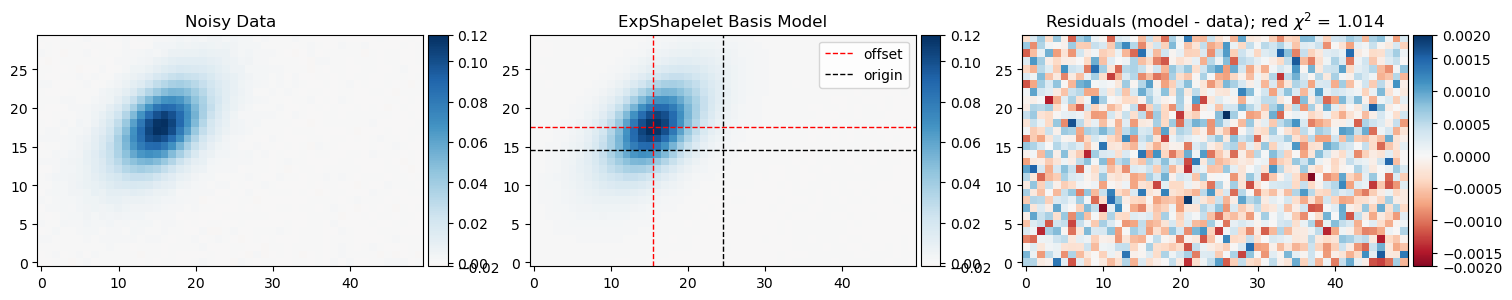

In [8]:
print(f'Using a beta of {fit_pars["scale_radius"]:.3f} arcsec')
print(f'Real scale radius: {scale_radius:.3f} arcsec')
exp_shapelet_pars = {
    'basis_type': 'exp_shapelets',
    'basis_plane': basis_plane,
    'basis_kwargs': {
        'nmax': 10,  # number of shapelet coefficients
        'beta': fit_pars['scale_radius'],
        # 'beta': scale_radius,
        'psf': psf,
    }
}

exp_shapelet_imap = build_intensity_map('basis', exp_shapelet_pars)

print(theta_pars)
exp_shapelet_image = exp_shapelet_imap.render(
    image_pars,
    theta_pars,
    None,
    image=image_noisy,
)

vmin = min(exp_shapelet_image.flatten().min(), image_noisy.flatten().min())
vmax = max(exp_shapelet_image.flatten().max(), image_noisy.flatten().max())
norm = MidpointNormalize(vmin=vmin, vmax=vmax)
cmap = 'RdBu'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

im = ax1.imshow(image_noisy, origin='lower', cmap=cmap, norm=norm)
ax1.set_title('Noisy Data')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)

im2 = ax2.imshow(exp_shapelet_image, origin='lower', cmap=cmap, norm=norm)
ax2.set_title('ExpShapelet Basis Model')
ax2.axvline(offset_pixels[0]+Nx/2.-0.5, color='r', linestyle='--', lw=1, label='offset')
ax2.axhline(offset_pixels[1]+Ny/2.-0.5, color='r', linestyle='--', lw=1)
ax2.axvline(Nx/2.-0.5, color='k', linestyle='--', lw=1, label='origin')
ax2.axhline(Ny/2.-0.5, color='k', linestyle='--', lw=1)
ax2.legend()
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

diff = exp_shapelet_image - image_noisy
imap_red_chi2 = np.sum((diff/noise_std)**2) / (image_noisy.size - len(fit_pars))
norm = MidpointNormalize(vmin=np.min(diff), vmax=np.max(diff))
im3 = ax3.imshow(diff, origin='lower', cmap=cmap, norm=norm)
ax3.set_title(f'Residuals (model - data); red $\chi^2$ = {imap_red_chi2:.3f}')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax)

plt.gcf().set_size_inches(18, 4)
plt.show()

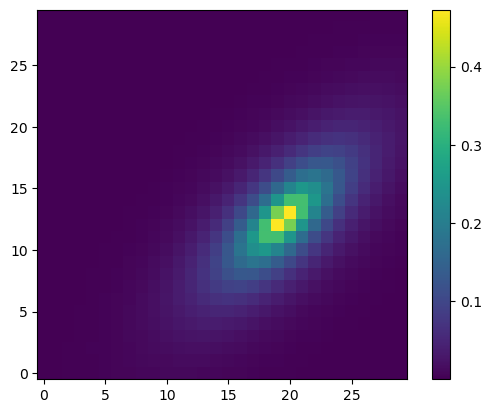

In [ ]:
# from kl_tools.basis import ExpShapeletBasis
# from kl_tools.parameters import ImagePars
# import matplotlib.pyplot as plt
# import numpy as np

# test_Nx, test_Ny = 30, 30
# test_pixel_scale = 0.5 # arcsec
# image_pars = ImagePars(
#     shape=(test_Ny, test_Nx),
#     indexing='ij',
#     pixel_scale=test_pixel_scale
# )

# test_basis = ExpShapeletBasis(
#     nmax=1,
#     beta=2.0, # arcsec
#     psf=None,
# )

# test_theta_pars = {
#     'sini': 0.9,
#     'theta_int': np.pi/4,
#     # 'theta_int': 0.0,
#     'x0': 5*test_pixel_scale,  # arcsec
#     'y0': -2*test_pixel_scale,  # arcsec
#     'g1': 0.0,
#     'g2': 0.0,
# }

# im = test_basis.render_im(
#     [1],
#     image_pars,
#     plane='disk',
#     transformation_pars=test_theta_pars,
# )

# plt.imshow(im, origin='lower')
# plt.colorbar()

In [10]:
# from kl_tools.basis import ExpShapeletBasis

# for beta in np.linspace(0.1, 1, 10):
#     basis = ExpShapeletBasis(beta=beta, nmax=1)
#     impars = ImagePars(shape=(1024,1024), pixel_scale=0.2)
#     basis_im = basis.render_im([1.0], impars)
#     # plt.imshow(basis_im, origin='lower', cmap='gray', norm='log')
#     # plt.colorbar()
#     # plt.show()
#     sum = np.sum(basis_im)
#     print(f"beta: {beta:.1f}; Sum of basis image: {sum}")


In [11]:
# # pixel_scale = 0.2
# # beta = 1.0
# beta = scale_radius
# basis = ExpShapeletBasis(beta=beta, nmax=1)
# image_pars = ImagePars(shape=(64,64), pixel_scale=pixel_scale)
# im = basis.render_im([1.0], image_pars)

# print("Image sum (no area):", np.sum(im))
# print("Image flux:", np.sum(im) * pixel_scale**2)
